# Download and inspect the Data

The easiest way to get the data is to download the data from here using your browser:
https://drive.google.com/drive/folders/0B3P9oO5A3RvSUW9qTG11Ul83TEE

We aren't doing this with python because its cumbersome to overcome google's filesize warning.  Place the zip file in this working directory before continuing.

In [1]:
# unzip the files
import zipfile
with zipfile.ZipFile('dataset-resized.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [2]:
# take a look inside the new folder
import os

data_path = 'dataset-resized'
categories = [f for f in os.listdir(data_path) 
              if os.path.isdir(os.path.join(data_path, f))]
categories

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [3]:
# count the number of images in each category
image_paths = {}
for cat in categories:
    image_paths[cat] = os.listdir(os.path.join(data_path,cat))
    print('There are', len(os.listdir(os.path.join(data_path,cat))), 
          cat, 
          'images' )
    

There are 594 paper images
There are 410 metal images
There are 403 cardboard images
There are 137 trash images
There are 501 glass images
There are 482 plastic images


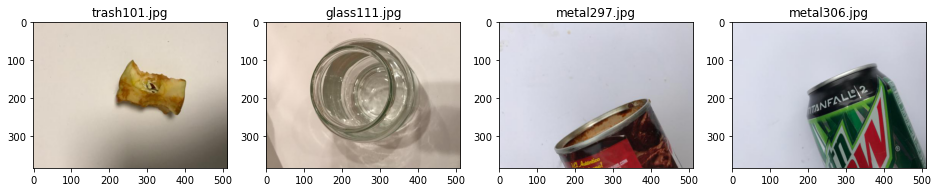

In [4]:
# take a look at some of the images
# inspect random images

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from tensorflow.keras.preprocessing.image import load_img

fig, axs = plt.subplots(1,4, figsize=(16,4))
                        
for ax in axs:
    # choose a random category
    cat = np.random.choice(categories)
    
    # choose a random image in that category
    file_name = np.random.choice(os.listdir(os.path.join(data_path,cat)))
    
    # load and display the image
    img = load_img(os.path.join(data_path,cat,file_name))
    ax.imshow(img)
    ax.set_title(file_name)

# Split into training and validation sets

In [5]:
split_base = 'data'

os.makedirs(split_base, exist_ok=True)

# store the path of each folder and create directories
train_folder = os.path.join(split_base, 'train')
os.makedirs(train_folder, exist_ok=True)

val_folder = os.path.join(split_base, 'validation')
os.makedirs(val_folder, exist_ok=True)

In [6]:
import shutil

# portion of images to be used for testing
val_portion = 0.10

# Split the data into training, validation, and split folders
for cat in categories:
    # get total number of files in this category
    num_files = len(image_paths[cat])
    
    # randomize the file order for this category
    np.random.shuffle(image_paths[cat])
    
    # set split boundries for validation and test
    val_boundry = int(np.floor(num_files * val_portion))
        
    # store boundries
    labels = {'validation': image_paths[cat][:val_boundry],
              'train': image_paths[cat][val_boundry:]}
    
    # loop through boundries and move copy files
    for label, files in labels.items():
        # create folder
        os.mkdir(os.path.join(split_base, label, cat))
        
        # copy files to the correct directory
        for file in files:
            shutil.copyfile(os.path.join(data_path, cat, file),
                            os.path.join(split_base, label, cat, file))


# Azure Setup

4  Setup Azure
In order to setup a workspace the following code should be run with your information substituted. This will have you authenticate and will allow store your connection information in the .azureml directory. All files run in this directory or its subdirectories will be able to access that config file for connecting to azure.

If the workspace does not exist it will be automatically created.

Replace `[your-subscription-id]` with your Azure subscription id.

In [7]:
from azureml.core import Workspace

subscription_id = '[your-subscription-id]'
resource_group = 'azure_trash_demo'
workspace_name = 'azure_trash_demo'
location='eastus'

ws = Workspace.create(workspace_name,
                             subscription_id=subscription_id, 
                             resource_group=resource_group,
                             location=location
)

ws.write_config(path='.azureml')

Deploying KeyVault with name azuretrakeyvault848f035f.
Deploying StorageAccount with name azuretrastorage443d53d76.
Deploying AppInsights with name azuretrainsights5ede111e.
Deployed AppInsights with name azuretrainsights5ede111e. Took 2.05 seconds.
Deployed KeyVault with name azuretrakeyvault848f035f. Took 18.52 seconds.
Deploying Workspace with name azure_trash_demo.
Deployed StorageAccount with name azuretrastorage443d53d76. Took 22.29 seconds.
Deployed Workspace with name azure_trash_demo. Took 19.13 seconds.


In [8]:
# get the workspace from the save workspace file
ws = Workspace.from_config()

## Create Compute Target

In [9]:
from azureml.core.compute import AmlCompute, ComputeTarget

# the name we are going to use to reference our cluster
compute_name = "gpu-cluster-NC6"

# the azure machine type 
vm_size = 'Standard_NC6_Promo'

# define the cluster and the max and min number of nodes
provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                            min_nodes = 0, 
                                                            max_nodes = 10)
# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

## Setup Run Enviorment

In [10]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# create an enviornment
env = Environment(name='waste-env-gpu')

# define packages for image
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 
                                            'azureml-defaults', 
                                            'tensorflow==2.4.0', 
                                            'Pillow'],
                             conda_packages=['SciPy'])

env.python.conda_dependencies = cd

# Specify a docker image to use.
env.docker.base_image = (
    "mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.0.3-cudnn8-ubuntu18.04"
)

# Register environment to re-use later
env = env.register(workspace = ws)

## Upload Data

In [11]:
datastore = ws.get_default_datastore()

# upload the data to the datastore
datastore.upload(src_dir='data/',
                 target_path='/data/',
                 overwrite=False,
                 show_progress=True)

Uploading an estimated of 2527 files
Uploading data/train/paper/paper283.jpg
Uploaded data/train/paper/paper283.jpg, 1 files out of an estimated total of 2527
Uploading data/train/paper/paper297.jpg
Uploaded data/train/paper/paper297.jpg, 2 files out of an estimated total of 2527
Uploading data/train/paper/paper526.jpg
Uploaded data/train/paper/paper526.jpg, 3 files out of an estimated total of 2527
Uploading data/train/paper/paper240.jpg
Uploaded data/train/paper/paper240.jpg, 4 files out of an estimated total of 2527
Uploading data/train/paper/paper532.jpg
Uploaded data/train/paper/paper532.jpg, 5 files out of an estimated total of 2527
Uploading data/train/paper/paper268.jpg
Uploaded data/train/paper/paper268.jpg, 6 files out of an estimated total of 2527
Uploading data/train/paper/paper491.jpg
Uploaded data/train/paper/paper491.jpg, 7 files out of an estimated total of 2527
Uploading data/train/paper/paper64.jpg
Uploaded data/train/paper/paper64.jpg, 8 files out of an estimated tot

Uploaded data/train/glass/glass265.jpg, 1508 files out of an estimated total of 2527
Uploading data/train/glass/glass271.jpg
Uploaded data/train/glass/glass271.jpg, 1509 files out of an estimated total of 2527
Uploading data/train/glass/glass339.jpg
Uploaded data/train/glass/glass339.jpg, 1510 files out of an estimated total of 2527
Uploading data/train/glass/glass477.jpg
Uploaded data/train/glass/glass477.jpg, 1511 files out of an estimated total of 2527
Uploading data/train/glass/glass305.jpg
Uploaded data/train/glass/glass305.jpg, 1512 files out of an estimated total of 2527
Uploading data/train/glass/glass463.jpg
Uploaded data/train/glass/glass463.jpg, 1513 files out of an estimated total of 2527
Uploading data/train/glass/glass488.jpg
Uploaded data/train/glass/glass488.jpg, 1514 files out of an estimated total of 2527
Uploading data/train/glass/glass113.jpg
Uploaded data/train/glass/glass113.jpg, 1515 files out of an estimated total of 2527
Uploading data/train/glass/glass107.jpg


Uploading data/validation/plastic/plastic348.jpg
Uploaded data/validation/plastic/plastic348.jpg, 2526 files out of an estimated total of 2527
Uploading data/validation/plastic/plastic46.jpg
Uploaded data/validation/plastic/plastic46.jpg, 2527 files out of an estimated total of 2527
Uploaded 2527 files


$AZUREML_DATAREFERENCE_a234a15621bd47b288a33e0d97499935

## Create a Dataset
A dataset is a reference to some data in a Datastore or on the internet.

In [12]:
from azureml.core import Dataset

# create the dataset object
dataset = Dataset.File.from_files(path=(datastore, '/data'))

# register the dataset for future use
dataset = dataset.register(workspace=ws,
                           name='waste_images',
                           description='Waste images divided into train/validation/split for classification')


# Continued in another notebook
In order to demonstrate loading in the resources we created above we will continue in the next notebook:
[2_Getting_started_with_Azure_for_Machine_Learning](2_Getting_started_with_Azure_for_Machine_Learning.ipynb)
